# ⚙️ Setup

In [1]:
import time
import requests
import re
import json
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
from PIL import Image as PILImage
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os
from matplotlib.colors import to_rgba
from urllib.parse import quote
from io import BytesIO

## 🏃‍♂️ Stats Functions (from Stats.ipynb)


In [2]:
STRAVA_CONFIG_PATH = "strava_config.json"

def load_strava_config():
    with open(STRAVA_CONFIG_PATH, "r") as f:
        return json.load(f)

def save_strava_config(config):
    with open(STRAVA_CONFIG_PATH, "w") as f:
        json.dump(config, f, indent=2)

def refresh_strava_token_if_needed():

    strava = load_strava_config()

    expires_at = strava.get("expires_at", 0)
    now = int(time.time())

    if expires_at - now < 300:
        print("🔄 Refreshing Strava token...")
        payload = {
            "grant_type": "refresh_token",
            "refresh_token": strava["refresh_token"],
            "client_id": strava["client_id"],
            "client_secret": strava["client_secret"]
        }
        response = requests.post("https://www.strava.com/oauth/token", data=payload)
        response.raise_for_status()
        tokens = response.json()

        strava["access_token"] = tokens["access_token"]
        strava["refresh_token"] = tokens["refresh_token"]
        strava["expires_at"] = tokens["expires_at"]

        save_strava_config(strava)
        print("✅ Strava token refreshed!")
        return tokens["access_token"]
    else:
        print("✅ Strava token is valid")
        return strava["access_token"]

access_token = refresh_strava_token_if_needed()
strava_headers = {"Authorization": f"Bearer {access_token}"}

🔄 Refreshing Strava token...
✅ Strava token refreshed!


In [3]:
def get_strava_activities(days_back=7, max_retries=3):
    import time
    from datetime import datetime, timedelta
    
    past_date = datetime.now() - timedelta(days=days_back)
    after_timestamp = int(past_date.timestamp())
    
    url = "https://www.strava.com/api/v3/athlete/activities"
    params = {
        'after': after_timestamp,
        'per_page': 50
    }
    
    for attempt in range(max_retries):
        try:
            response = requests.get(url, headers=strava_headers, params=params)
            response.raise_for_status()
            activities = response.json()
            if attempt > 0:
                print(f"✅ Strava API recovered after {attempt + 1} attempts")
            return activities
        except requests.exceptions.HTTPError as e:
            if response.status_code == 500 and attempt < max_retries - 1:
                wait_time = (attempt + 1) * 2  # Exponential backoff: 2, 4, 6 seconds
                print(f"⚠️ Strava API returned 500 error (attempt {attempt + 1}/{max_retries}). Retrying in {wait_time}s...")
                time.sleep(wait_time)
                continue
            else:
                print(f"❌ Error fetching Strava activities: {e}")
                if response.status_code == 500:
                    print("💡 This appears to be a temporary server issue. The data may be available if you try again.")
                return []
        except Exception as e:
            print(f"❌ Error fetching Strava activities: {e}")
            return []
    
    return []

def get_week_start():
    today = datetime.now()
    monday = today - timedelta(days=today.weekday())
    return monday.replace(hour=0, minute=0, second=0, microsecond=0)

def get_weekly_running_total():
    week_start = get_week_start()
    days_since_monday = (datetime.now() - week_start).days + 1
    activities = get_strava_activities(days_back=days_since_monday)
    
    week_start_timestamp = week_start.timestamp()
    running_distance = 0
    
    running_types = ['Run', 'TrailRun', 'VirtualRun']
    
    for activity in activities:
        activity_date = datetime.strptime(activity.get('start_date_local'), '%Y-%m-%dT%H:%M:%SZ')
        if activity_date.timestamp() >= week_start_timestamp:
            activity_type = activity.get("type", "")
            if activity_type in running_types:
                distance_km = activity.get("distance", 0) / 1000
                running_distance += distance_km
    
    return f"{round(running_distance, 1)} km"

def get_weekly_weight_training_total():
    week_start = get_week_start()
    days_since_monday = (datetime.now() - week_start).days + 1
    activities = get_strava_activities(days_back=days_since_monday)
    
    week_start_timestamp = week_start.timestamp()
    weight_training_hours = 0
    
    weight_training_types = ['WeightTraining', 'Workout']
    
    for activity in activities:
        activity_date = datetime.strptime(activity.get('start_date_local'), '%Y-%m-%dT%H:%M:%SZ')
        if activity_date.timestamp() >= week_start_timestamp:
            activity_type = activity.get("type", "")
            if activity_type in weight_training_types:
                duration_seconds = activity.get("moving_time", 0)
                duration_hours = duration_seconds / 3600
                weight_training_hours += duration_hours
    
    return f"{round(weight_training_hours, 1)} hours"

def create_progress_bar(current, target, bar_length=30):
    progress = min(current / target, 1.0)
    filled_length = int(bar_length * progress)
    bar = '█' * filled_length + '░' * (bar_length - filled_length)
    percentage = progress * 100
    return bar, percentage

def display_running_progress(target_km=15):
    current_distance_str = get_weekly_running_total()
    current_distance = float(current_distance_str.replace(' km', ''))

    progress_bar, percentage = create_progress_bar(current_distance, target_km)
    print(progress_bar)

def display_weight_training_progress(target_hours=2):
    current_hours_str = get_weekly_weight_training_total()
    current_hours = float(current_hours_str.replace(' hours', ''))
    
    progress_bar, percentage = create_progress_bar(current_hours, target_hours)
    print(progress_bar)

def agility_progress_percentage(target_km=15):
    current_distance_str = get_weekly_running_total()  # e.g. "12.3 km"
    current_distance = float(current_distance_str.replace(" km", ""))
    if target_km <= 0:
        return 0
        
    percentage = (current_distance / target_km) * 100
    return min(100, max(0, round(percentage, 1)))

def strength_progress_percentage(target_hours=2):
    current_hours_str = get_weekly_weight_training_total()  # e.g. "1.5 hours"
    current_hours = float(current_hours_str.replace(" hours", ""))
    if target_hours <= 0:
        return 0

    percentage = (current_hours / target_hours) * 100
    return min(100, max(0, round(percentage, 1)))

## 💰 Prices Functions (from Prices.ipynb)


In [4]:
def proper_title(text):
    """Custom title function that doesn't capitalize letters after apostrophes"""
    words = text.split()
    result = []
    for word in words:
        if "'" in word:
            # Split on apostrophe and handle each part
            parts = word.split("'")
            titled_parts = [parts[0].capitalize()]  # Capitalize first part
            for part in parts[1:]:
                titled_parts.append(part.lower())  # Keep rest lowercase
            result.append("'".join(titled_parts))
        else:
            result.append(word.capitalize())
    return " ".join(result)

def load_items_dict():
    """Load OSRS items from file into a dictionary for fast lookup"""
    items_dict = {}
    try:
        with open('osrs_items.txt', 'r', encoding='utf-8') as file:
            for line in file:
                line = line.strip()
                if ':' in line:
                    item_id, item_name = line.split(':', 1)
                    item_id = int(item_id.strip())
                    item_name = item_name.strip()
                    # Store with lowercase name for case-insensitive lookup
                    items_dict[item_name.lower()] = item_id
        return items_dict
    except FileNotFoundError:
        print("❌ osrs_items.txt file not found!")
        return {}
    except Exception as e:
        print(f"❌ Error loading items: {e}")
        return {}

def get_item_id(item_name, items_dict=None):
    """Get item ID from item name (case-insensitive)"""
    if items_dict is None:
        items_dict = load_items_dict()
    
    # Try exact match first (case-insensitive)
    item_name_lower = item_name.lower()
    if item_name_lower in items_dict:
        return items_dict[item_name_lower]
    
    # Try partial match if exact match fails
    matches = []
    for name, item_id in items_dict.items():
        if item_name_lower in name:
            matches.append((name, item_id))
    
    if len(matches) == 1:
        print(f"📍 Found match: {matches[0][0]}")
        return matches[0][1]
    elif len(matches) > 1:
        print(f"❌ Multiple matches found for '{item_name}':")
        for name, item_id in matches[:5]:  # Show first 5 matches
            print(f"   • {name} (ID: {item_id})")
        return None
    else:
        print(f"❌ No item found for '{item_name}'")
        return None

def format_price(price):
    """Format price with K/M suffixes using 4 significant figures"""
    if price >= 10000000:  # 10M+: use M suffix
        millions = price / 1000000
        formatted = f'{millions:.4g}M'  # .4g gives exactly 4 sig figs
        return formatted
    elif price >= 10000:  # 10K-9.999M: use K suffix
        thousands = price / 1000
        formatted = f'{thousands:.4g}K'  # .4g gives exactly 4 sig figs
        return formatted
    else:  # Below 10K: show full number
        return f'{price:.4g}'  # 4 sig figs, no suffix

def get_current_price(item_name_or_id, formatted=True, items_dict=None):
    """Get current market price for an item
    
    Args:
        item_name_or_id: The OSRS item name (case insensitive) or item ID
        formatted: If True, returns formatted price (e.g., "39.39M"). If False, returns raw number.
        items_dict: Optional items dictionary for faster lookups
    """
    try:
        # Check if input is already an item ID (integer or string of digits)
        if isinstance(item_name_or_id, int) or (isinstance(item_name_or_id, str) and item_name_or_id.isdigit()):
            item_id = int(item_name_or_id)
        else:
            # It's an item name, convert to ID
            if items_dict is None:
                items_dict = load_items_dict()
            item_id = get_item_id(item_name_or_id, items_dict)
            if item_id is None:
                return None
        
        url = f"https://prices.runescape.wiki/api/v1/osrs/latest?id={item_id}"
        response = requests.get(url, headers={"User-Agent": "RuneSync Price Tracker"})
        data = response.json()
        
        item_data = data.get('data', {}).get(str(item_id), {})
        current_price = item_data.get('high', 0) or item_data.get('low', 0)
        
        if current_price and formatted:
            return format_price(current_price)
        
        return current_price
    except:
        return None

def get_24h_change(item_name_or_id, items_dict=None):
    """Get 24-hour price change percentage
    
    Args:
        item_name_or_id: The OSRS item name (case insensitive) or item ID
        items_dict: Optional items dictionary for faster lookups
    """
    try:
        # Check if input is already an item ID (integer or string of digits)
        if isinstance(item_name_or_id, int) or (isinstance(item_name_or_id, str) and item_name_or_id.isdigit()):
            item_id = int(item_name_or_id)
        else:
            # It's an item name, convert to ID
            if items_dict is None:
                items_dict = load_items_dict()
            item_id = get_item_id(item_name_or_id, items_dict)
            if item_id is None:
                return None
        
        # Get 6-hour data points
        url = f"https://prices.runescape.wiki/api/v1/osrs/timeseries?timestep=6h&id={item_id}"
        response = requests.get(url, headers={"User-Agent": "RuneSync Price Tracker"})
        data = response.json()
        
        price_history = data.get('data', [])
        if len(price_history) < 4:  # Need at least 4 points for 24h
            return None
        
        current_price = get_current_price(item_id, formatted=False)
        if not current_price:
            return None
        
        # Get price from 24 hours ago (4 data points * 6h = 24h)
        price_24h_ago = price_history[-4].get('avgHighPrice') or price_history[-4].get('avgLowPrice', 0)
        
        if price_24h_ago > 0:
            change_pct = ((current_price - price_24h_ago) / price_24h_ago) * 100
            # Add '+' for non-negative values, keep 1 decimal place
            if change_pct >= 0:
                return f"+{change_pct:.1f}%"
            else:
                return f"{change_pct:.1f}%"
        
        return None
    except:
        return None

def get_7d_change(item_name_or_id, items_dict=None):
    """Get 7-day price change percentage
    
    Args:
        item_name_or_id: The OSRS item name (case insensitive) or item ID
        items_dict: Optional items dictionary for faster lookups
    """
    try:
        # Check if input is already an item ID (integer or string of digits)
        if isinstance(item_name_or_id, int) or (isinstance(item_name_or_id, str) and item_name_or_id.isdigit()):
            item_id = int(item_name_or_id)
        else:
            # It's an item name, convert to ID
            if items_dict is None:
                items_dict = load_items_dict()
            item_id = get_item_id(item_name_or_id, items_dict)
            if item_id is None:
                return None
        
        # Get 6-hour data points
        url = f"https://prices.runescape.wiki/api/v1/osrs/timeseries?timestep=6h&id={item_id}"
        response = requests.get(url, headers={"User-Agent": "RuneSync Price Tracker"})
        data = response.json()
        
        price_history = data.get('data', [])
        if len(price_history) < 28:  # Need at least 28 points for 7d
            return None
        
        current_price = get_current_price(item_id, formatted=False)
        if not current_price:
            return None
        
        # Get price from 7 days ago (28 data points * 6h = 168h = 7d)
        price_7d_ago = price_history[-28].get('avgHighPrice') or price_history[-28].get('avgLowPrice', 0)
        
        if price_7d_ago > 0:
            change_pct = ((current_price - price_7d_ago) / price_7d_ago) * 100
            # Add '+' for non-negative values, keep 1 decimal place
            if change_pct >= 0:
                return f"+{change_pct:.1f}%"
            else:
                return f"{change_pct:.1f}%"
        
        return None
    except:
        return None


def create_7d_chart(item_name_or_id, width=143, height=110, items_dict=None):
    """Create a compact 7-day price chart with OSRS styling
    
    Args:
        item_name_or_id: The OSRS item name (case insensitive) or item ID
        width: Chart width in pixels
        height: Chart height in pixels
        items_dict: Optional items dictionary for faster lookups
    """
    try:
        # Check if input is already an item ID (integer or string of digits)
        if isinstance(item_name_or_id, int) or (isinstance(item_name_or_id, str) and item_name_or_id.isdigit()):
            item_id = int(item_name_or_id)
        else:
            # It's an item name, convert to ID
            if items_dict is None:
                items_dict = load_items_dict()
            item_id = get_item_id(item_name_or_id, items_dict)
            if item_id is None:
                return None
        
        # Get 6-hour data points for last 7 days
        url = f"https://prices.runescape.wiki/api/v1/osrs/timeseries?timestep=6h&id={item_id}"
        response = requests.get(url, headers={"User-Agent": "RuneSync Price Tracker"})
        data = response.json()
        
        price_history = data.get('data', [])
        if len(price_history) < 28:
            print("❌ Insufficient data for 7-day chart")
            return None
        
        # Take last 28 data points (7 days * 4 per day)
        recent_data = price_history[-28:]
        
        # Extract prices and timestamps
        prices = []
        timestamps = []
        
        for entry in recent_data:
            price = entry.get('avgHighPrice') or entry.get('avgLowPrice', 0)
            timestamp = entry.get('timestamp', 0)
            
            if price > 0:
                prices.append(price)
                timestamps.append(datetime.fromtimestamp(timestamp))
        
        if len(prices) < 2:
            print("❌ No valid price data")
            return None
        
        # Load RuneScape font
        runescape_font = None
        try:
            # Try assets folder relative to current location
            font_path = 'assets/runescape_uf.ttf'
            if os.path.exists(font_path):
                # Add font to matplotlib's font manager
                fm.fontManager.addfont(font_path)
                runescape_font = fm.FontProperties(fname=font_path)
                # Get the actual font name from the file
                font_name = runescape_font.get_name()
                plt.rcParams['font.family'] = font_name
                # Font loaded successfully
            else:
                print("⚠️ RuneScape font not found, using default font")
        except Exception as e:
            print(f"⚠️ Font loading error: {e}, using default font")
        
        # Create compact figure
        fig_width = width / 100
        fig_height = height / 100
        plt.figure(figsize=(fig_width, fig_height), dpi=100)
        
        # OSRS stone tile theme with transparency layers
        line_color = '#ffff00'      # Bright yellow line
        axes_color = '#8B7355'      # Stone brown axes
        text_color = '#ffff00'      # Bright yellow text
        grid_color = '#6B5B47'      # Darker stone for grid lines
        tile_bg = '#5D4E37'         # Brown tile color (will be translucent)
        tile_border = '#8B7355'     # Lighter brown for tile border
        
        # Set figure background to transparent (outside plotted area)
        fig = plt.gcf()
        fig.patch.set_facecolor('none')  # Completely transparent figure background
        
        # Remove all margins and padding for maximum chart space
        plt.subplots_adjust(left=0.12, right=0.96, top=0.96, bottom=0.12)
        
        # Get axes and set translucent stone tile background
        ax = plt.gca()
        # Convert hex color to RGBA with 40% opacity so gray tile shows through
        translucent_bg = (*to_rgba(tile_bg)[:3], 0.4)  # 40% opacity
        ax.set_facecolor(translucent_bg)  # Translucent stone tile chart background
        
        # Add subtle tile border effect (like OSRS interface)
        for spine in ax.spines.values():
            spine.set_color(tile_border)
            spine.set_linewidth(1.5)  # Slightly thicker for tile effect
        
        # Plot the line with bright yellow
        plt.plot(timestamps, prices, linewidth=2, color=line_color, marker='o', markersize=1.5)
        
        # Calculate price levels for y-axis
        min_price = min(prices)
        max_price = max(prices)
        mid_price = (min_price + max_price) / 2
        
        # Set y-axis ticks and labels (min, mid, max)
        # plt.yticks([min_price, mid_price, max_price], 
        #           [format_price(min_price), format_price(mid_price), format_price(max_price)])
        plt.yticks([])
        
        # Remove x-axis date labels but keep grid lines for each day
        # Create daily timestamps for grid lines
        daily_timestamps = []
        start_date = timestamps[0].replace(hour=0, minute=0, second=0, microsecond=0)
        for i in range(8):  # 7 days + 1 for end
            daily_timestamps.append(start_date + timedelta(days=i))
        
        # Set x-axis with no labels or ticks but keep daily grid lines
        plt.xticks(daily_timestamps, [''] * len(daily_timestamps))
        ax.tick_params(axis='x', bottom=False)
        
        # Custom grid - horizontal lines at min, mid, max and vertical lines for each day
        ax.grid(True, which='major', axis='y', color=grid_color, alpha=0.3, linewidth=0.8)
        ax.grid(True, which='major', axis='x', color=grid_color, alpha=0.3, linewidth=0.8)
        
        # Hide all tick marks and labels
        ax.tick_params(axis='x', colors=text_color, labelsize=11, bottom=False)
        ax.tick_params(axis='y', colors=text_color, labelsize=11, left=False, labelleft=False)
        # if runescape_font:
        #     # Apply RuneScape font to y-axis labels with explicit size
        #     runescape_font.set_size(11)
        #     for label in ax.get_yticklabels():
        #         label.set_fontproperties(runescape_font)
        
        # Remove axis labels and title
        plt.xlabel('')
        plt.ylabel('')
        plt.title('')
        plt.tight_layout()
        
        buf = BytesIO()
        plt.savefig(buf, format='png', dpi=100, bbox_inches='tight', 
                   facecolor='none', edgecolor='none', transparent=False)
        buf.seek(0)
        
        # Convert to PIL Image
        chart_image = PILImage.open(buf)
        
        # Resize to the specified dimensions
        chart_image = chart_image.resize((width, height), PILImage.Resampling.LANCZOS)
        
        # Close the matplotlib figure to free memory
        plt.close()
        
        return chart_image
        
    except Exception as e:
        print(f"❌ Chart error: {e}")
        return None

def get_item_info_by_name(item_name, items_dict=None):
    """Get all price info for an item by name"""
    if items_dict is None:
        items_dict = load_items_dict()
    
    item_id = get_item_id(item_name, items_dict)
    if item_id is None:
        return None
    
    print(f"🏷️  Item: {item_name} (ID: {item_id})")
    
    # Pass items_dict for efficiency since we already loaded it
    current_price = get_current_price(item_id, items_dict=items_dict)
    if current_price:
        print(f"💰 Current Price: {current_price}")
        print(f"📈 24 Hour Change: {get_24h_change(item_id, items_dict=items_dict)}")
        print(f"📊 7 Day Change: {get_7d_change(item_id, items_dict=items_dict)}")
        create_7d_chart(item_id, items_dict=items_dict)
    else:
        print("❌ Could not fetch price data")
    
    return item_id

def get_item_inventory_image(item_name, save_path=None, show_image=True):
    """Get the inventory image for an OSRS item from the wiki
    
    Args:
        item_name: The OSRS item name (case insensitive)
        save_path: Optional path to save the image file (e.g., 'images/bond.png')
        show_image: If True, displays the image when found
    
    Returns:
        PIL Image object if successful, None if failed
    """
    try:
        # Clean and format the item name for wiki URL
        clean_name = re.sub(r'[^\w\s\'-]', '', item_name)
        clean_name = clean_name.strip()
        
        # Try different wiki URL formats (some items use different capitalization)
        try:
            words = clean_name.split()
            if len(words) == 2:
                # For two words like "ancient godsword" -> "Ancient_godsword"
                url_variants = [
                    f"{words[0].capitalize()}_{words[1]}",  # Ancient_godsword
                    '_'.join(word.capitalize() for word in words),  # Ancient_Godsword
                    clean_name.replace(' ', '_'),  # ancient_godsword
                ]
            else:
                # For other cases, use standard capitalization
                url_variants = [
                    '_'.join(word.capitalize() for word in words),
                    clean_name.replace(' ', '_'),
                                 ]
        except Exception as e:
            return None
        
        headers = {"User-Agent": "RuneSync Image Fetcher"}
        
        # Try different URL formats until we find the page
        response = None
        working_wiki_name = None
        
        for wiki_name in url_variants:
            page_url = f"https://oldschool.runescape.wiki/w/{quote(wiki_name)}"
            response = requests.get(page_url, headers=headers, timeout=10)
            
            if response.status_code == 200:
                working_wiki_name = wiki_name
                break
        
        if response and response.status_code == 200:
            html_content = response.text
            
            # Look for inventory image references in the page HTML
            image_patterns = [
                r'File:([^"]*?\.png)',  # General file references
                r'src="[^"]*?/images/([^"]*?\.png)"',  # Direct image sources
                r'href="[^"]*?/images/([^"]*?\.png)"'  # Image links
            ]
            
            for pattern in image_patterns:
                matches = re.findall(pattern, html_content, re.IGNORECASE)
                for match in matches:
                    # Filter for likely inventory images (avoid large detailed images)
                    if any(keyword in match.lower() for keyword in ['detail', 'equipped', 'large']):
                        continue
                    
                    # Look for simple inventory images that match the item name
                    if match.strip('/').endswith('.png'):
                        filename = match.split('/')[-1]  # Get just the filename
                        
                        # More comprehensive name matching patterns
                        filename_base = filename.lower().replace('.png', '')
                        
                        # Generate many possible name variations to match against
                        name_variations = [
                            item_name.lower(),
                            item_name.lower().replace(' ', '_'),
                            working_wiki_name.lower(),
                            working_wiki_name.replace('_', ' ').lower(),
                            # Additional patterns for common cases
                            '_'.join(word.lower() for word in item_name.split()),
                            '_'.join(word.capitalize() for word in item_name.split()).lower(),
                            # Handle the specific wiki name format that was found
                            f"{item_name.split()[0].capitalize()}_{item_name.split()[1].lower()}".lower() if len(item_name.split()) == 2 else item_name.lower()
                        ]
                        
                        # Remove duplicates while preserving order
                        name_variations = list(dict.fromkeys(name_variations))
                        
                        # Check if this filename matches our item (and isn't a detail/equipped version)
                        is_basic_item = any(filename_base == var for var in name_variations)
                        is_not_detail = not any(keyword in filename.lower() for keyword in ['detail', 'equipped', 'large', 'p)', 'p+)'])
                        

                        
                        if is_basic_item and is_not_detail:
                            try:
                                # Build the full image URL
                                if match.startswith('/images/'):
                                    image_url = f"https://oldschool.runescape.wiki{match}"
                                else:
                                    image_url = f"https://oldschool.runescape.wiki/images/{quote(filename)}"
                                
                                img_response = requests.get(image_url, headers=headers, timeout=10)
                                
                                if img_response.status_code == 200:
                                    image = Image.open(BytesIO(img_response.content))
                                    width, height = image.size
                                    
                                    # Accept inventory icons (allow for smaller items like daggers)
                                    if 8 <= width <= 64 and 8 <= height <= 64:
                                        if save_path:
                                            os.makedirs(os.path.dirname(save_path), exist_ok=True)
                                            image.save(save_path)
                                        
                                        # Display the image if requested
                                        if show_image:
                                            from IPython.display import display
                                            display(image)
                                        
                                        return image
                                        
                            except Exception as e:
                                continue
        
        return None
        
    except Exception as e:
        return None

def display_item_with_image(item_name):
    """Display just the inventory image for an item"""
    image = get_item_inventory_image(item_name)
    if image:
        plt.figure(figsize=(2, 2))
        plt.imshow(image)
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        return image

## 🌤️ Weather Functions (from Weather.ipynb)


In [5]:
with open("weather_config.json", "r") as f:
    weather_config = json.load(f)

weather_api_key = weather_config["api_key"]
current_weather_url = weather_config["endpoints"]["current_weather"]
forecast_url = weather_config["endpoints"]["forecast"]
default_units = weather_config["default_units"]
default_city = weather_config["default_city"]

In [6]:
def _fetch_weather_data(city):
    url = f"{current_weather_url}?q={city}&appid={weather_api_key}&units={default_units}"
    response = requests.get(url)
    response.raise_for_status()
    return response.json()

def _fetch_forecast_data(city):
    url = f"{forecast_url}?q={city}&appid={weather_api_key}&units={default_units}"
    response = requests.get(url)
    response.raise_for_status()
    return response.json()

def get_temperature(city=None):
    if not city:
        city = default_city
    try:
        weather_data = _fetch_weather_data(city)
        temp = weather_data['main']['temp']
        return f"{round(temp)}"
    except Exception as e:
        print(f"❌ Error getting temperature for {city}: {e}")
        return None

def get_daily_high_temperature(city=None):
    """Get the actual daily high (maximum) temperature for today from forecast data"""
    if not city:
        city = default_city
    try:
        from datetime import datetime
        
        # Get forecast data which has more accurate daily highs
        forecast_data = _fetch_forecast_data(city)
        
        if not forecast_data or not forecast_data.get('list'):
            # Fallback to current weather data if forecast fails
            weather_data = _fetch_weather_data(city)
            temp_max = weather_data['main']['temp_max']
            return f"{round(temp_max)}"
        
        # Find the highest temperature for today from forecast
        today = datetime.now().date()
        max_temp_today = None
        
        for item in forecast_data['list']:
            forecast_time = datetime.fromtimestamp(item['dt'])
            if forecast_time.date() == today:
                temp_max = item['main']['temp_max']
                if max_temp_today is None or temp_max > max_temp_today:
                    max_temp_today = temp_max
        
        if max_temp_today is not None:
            return f"{round(max_temp_today)}"
        else:
            # Fallback to current weather data if no today forecast found
            weather_data = _fetch_weather_data(city)
            temp_max = weather_data['main']['temp_max']
            return f"{round(temp_max)}"
            
    except Exception as e:
        print(f"❌ Error getting daily high temperature for {city}: {e}")
        return None

def get_wind_level(city=None):
    if not city:
        city = default_city
    try:
        weather_data = _fetch_weather_data(city)
        wind_speed_ms = weather_data.get('wind', {}).get('speed', 0)
        
        if wind_speed_ms < 1.5:
            return "Very Low"
        elif wind_speed_ms < 3.5:
            return "Low"
        elif wind_speed_ms < 6:
            return "Medium" 
        elif wind_speed_ms < 10:
            return "High"
        else:
            return "Very High"
    except Exception as e:
        print(f"❌ Error getting wind level for {city}: {e}")
        return None

def get_rain_chance(city=None):
    if not city:
        city = default_city
    try:
        forecast_data = _fetch_forecast_data(city)
        if forecast_data and forecast_data.get('list'):
            next_forecast = forecast_data['list'][0]
            rain_probability = next_forecast.get('pop', 0) * 100
            return f"{round(rain_probability)}%"
        else:
            return 0
    except Exception as e:
        print(f"❌ Error getting rain chance for {city}: {e}")
        return None

def get_simple_condition(city=None):
    if not city:
        city = default_city
    try:
        weather_data = _fetch_weather_data(city)
        main_condition = weather_data['weather'][0]['main'].lower()
        
        condition_map = {
            'clear': "Clear",
            'clouds': "Cloudy", 
            'rain': "Rain",
            'drizzle': "Rain",
            'thunderstorm': "Thunder",
            'snow': "Snow"
        }
        
        if main_condition in condition_map:
            return condition_map[main_condition]
        elif main_condition in ['mist', 'fog', 'haze']:
            return "Foggy"
        else:
            return weather_data['weather'][0]['main']
    except Exception as e:
        print(f"❌ Error getting condition for {city}: {e}")
        return None

def get_sunset_time(city=None):
    if not city:
        city = default_city
    try:
        weather_data = _fetch_weather_data(city)
        sunset_timestamp = weather_data['sys']['sunset']
        return datetime.fromtimestamp(sunset_timestamp).strftime('%H:%M')
    except Exception as e:
        print(f"❌ Error getting sunset time for {city}: {e}")
        return None

def get_sunrise_time(city=None):
    if not city:
        city = default_city
    try:
        weather_data = _fetch_weather_data(city)
        sunrise_timestamp = weather_data['sys']['sunrise']
        return datetime.fromtimestamp(sunrise_timestamp).strftime('%H:%M')
    except Exception as e:
        print(f"❌ Error getting sunrise time for {city}: {e}")
        return None

## 📰 News Functions (from News.ipynb)


In [7]:
def get_osrs_title():
    try:
        url = "https://oldschool.runescape.com/"
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'}
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        
        soup = BeautifulSoup(response.content, 'html.parser')
        
        news_container = (soup.find('div', class_=re.compile(r'news')) or 
                         soup.find('section', class_=re.compile(r'news')) or
                         soup.find('article') or
                         soup.find('div', string=re.compile(r'news', re.I)))
        
        if news_container:
            title_elem = (news_container.find('h1') or 
                         news_container.find('h2') or 
                         news_container.find('h3') or
                         news_container.find('a'))
            
            if title_elem:
                title = title_elem.get_text().strip()
                title = re.sub(r'\s+', ' ', title)
                return title[:100] if title else "No title found"
        
        return "Latest OSRS News"
        
    except Exception as e:
        print(f"❌ Error fetching OSRS title: {e}")
        return "Error fetching title"

def get_osrs_abstract():
    try:
        url = "https://oldschool.runescape.com/"
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'}
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        
        soup = BeautifulSoup(response.content, 'html.parser')
        
        news_container = (soup.find('div', class_=re.compile(r'news')) or 
                         soup.find('section', class_=re.compile(r'news')) or
                         soup.find('article'))
        
        if news_container:
            desc_elem = (news_container.find('p') or 
                        news_container.find('div', class_=re.compile(r'desc|summary|content')))
            
            if desc_elem:
                abstract = desc_elem.get_text().strip()
                abstract = re.sub(r'\s+', ' ', abstract)

                # Remove "read more..." text (case insensitive)
                abstract = re.sub(r'\s*read\s+more\.{3,}\s*$', '', abstract, flags=re.IGNORECASE)
                abstract = re.sub(r'\s*read\s+more\s*$', '', abstract, flags=re.IGNORECASE)


                if len(abstract) > 140:
                    abstract = abstract[:140].rsplit(' ', 1)[0] + "..."
                return abstract if abstract else "Check oldschool.runescape.com for latest updates"
        
        return "Check oldschool.runescape.com for latest updates"
        
    except Exception as e:
        print(f"❌ Error fetching OSRS abstract: {e}")
        return "Error fetching abstract"

def get_osrs_image(target_width=120, target_height=67):
    try:
        url = "https://oldschool.runescape.com/"
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'}
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        
        soup = BeautifulSoup(response.content, 'html.parser')
        
        news_container = (soup.find('div', class_=re.compile(r'news')) or 
                         soup.find('section', class_=re.compile(r'news')) or
                         soup.find('article'))
        
        image_url = None
        
        if news_container:
            img_elem = news_container.find('img')
            if img_elem:
                image_url = img_elem.get('src')
                
                if image_url and image_url.startswith('/'):
                    image_url = f"https://oldschool.runescape.com{image_url}"
                elif image_url and image_url.startswith('//'):
                    image_url = f"https:{image_url}"
        
        if not image_url:
            img_elem = soup.find('img', src=True)
            if img_elem:
                image_url = img_elem.get('src')
                if image_url and image_url.startswith('/'):
                    image_url = f"https://oldschool.runescape.com{image_url}"
                elif image_url and image_url.startswith('//'):
                    image_url = f"https:{image_url}"
        
        if not image_url:
            print("❌ No image found for news article")
            return None
        
        try:
            img_response = requests.get(image_url, headers=headers)
            img_response.raise_for_status()
            
            from io import BytesIO
            img = PILImage.open(BytesIO(img_response.content))
            img = img.resize((target_width, target_height), PILImage.Resampling.LANCZOS)
            return img
            
        except Exception as e:
            print(f"❌ Error processing image: {e}")
            return None
        
    except Exception as e:
        print(f"❌ Error fetching OSRS image: {e}")
        return None

# 🎮 Demo

### 📈 Prices
**Display the current price and 7-day price history for a chosen item**

In [8]:
item_name = "osmumten's fang"

print(proper_title(item_name))
print(f"🏷️ Current Price: {get_current_price(item_name)}")
print(f"📈 24 Hour Change: {get_24h_change(item_name)}")
print(f"📈 7 Day Change: {get_7d_change(item_name)}")
create_7d_chart(item_name);

Osmumten's Fang
🏷️ Current Price: 21.41M
📈 24 Hour Change: +3.1%
📈 7 Day Change: +0.8%


### 📰 News
**Get the latest OSRS news**

Pet Insurance Rework & More
Free Pet reclaims, rescued sheep and Clan QOL improvements are here!


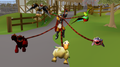

In [9]:
print(get_osrs_title())
print(get_osrs_abstract())
display(get_osrs_image())

### 🏃‍♂️ Training
**Weekly training summary with progress bars for defined targets**

In [10]:
print(f"🏃‍♂️ Agility: {get_weekly_running_total()}")
display_running_progress()
print(f"💪 Strength: {get_weekly_weight_training_total()}")
display_weight_training_progress()

🏃‍♂️ Agility: 5.2 km
██████████░░░░░░░░░░░░░░░░░░░░
💪 Strength: 1.5 hours
██████████████████████░░░░░░░░


### 🌤️ Weather
**Change the city below to get weather for any location**

In [11]:
city = "Eccleston Park"

print(f"🌤️ Weather in {city}:")
print("-" * 30)
print(f"🌡️ Temperature: {get_temperature(city)}")
print(f"🔥 Daily High: {get_daily_high_temperature(city)}")
print(f"💨 Wind Level: {get_wind_level(city)}")
print(f"🌧️ Rain Chance: {get_rain_chance(city)}") 
print(f"☁️ Condition: {get_simple_condition(city)}")
print(f"🌅 Sunset: {get_sunset_time(city)}")
print()

🌤️ Weather in Eccleston Park:
------------------------------
🌡️ Temperature: 11
🔥 Daily High: 11
💨 Wind Level: Medium
🌧️ Rain Chance: 100%
☁️ Condition: Cloudy
🌅 Sunset: 19:37



# ☁️ Pillow
**Render the dashboard**

In [12]:
# Import the necessary libraries
from PIL import Image, ImageDraw, ImageFont

# Load the background image
bg = Image.open("assets/background.png")
draw = ImageDraw.Draw(bg)

# Load the font
text = ImageFont.truetype("assets/runescape_uf.ttf", 16)
time_subtitle = ImageFont.truetype("assets/runescape_uf.ttf", 24)
time_title = ImageFont.truetype("assets/runescape_uf.ttf", 100)

# Function to wrap text based on pixel width
def wrap_text(text, font, max_width):
    """
    Wrap text to fit within a specified pixel width.
    Returns a list of lines that fit within the max_width.
    """
    words = text.split(' ')
    lines = []
    current_line = ""
    
    for word in words:
        # Test if adding this word would exceed the max width
        test_line = current_line + (" " if current_line else "") + word
        bbox = draw.textbbox((0, 0), test_line, font=font)
        text_width = bbox[2] - bbox[0]
        
        if text_width <= max_width:
            current_line = test_line
        else:
            # If current_line is empty, the single word is too long
            if current_line:
                lines.append(current_line)
                current_line = word
            else:
                # Single word is too long, add it anyway
                lines.append(word)
                current_line = ""
    
    if current_line:
        lines.append(current_line)
    
    return lines

# Define the functions for the price pane
def price_name():
    return proper_title(item_name)

def price_current():
    return "Current:"

#def price_current_metric():
    #return "17.39K"

def price_24h():
    return "24h:"

#def price_24h_metric():
    #return "+0.9%"
    
def price_7d():
    return "7d:"

#def price_7d_metric():
    #return "+0.4%"

#def price_chart():
    #return "IMAGE HERE"
    
# Define the functions for the news pane
#def news_title():
    #return "Sailing Skill-Cape & Icon Shortlist"

#def news_abstract():
    #return "Waves crash, stars shimmer, and the night hums softly; somewhere, dreams begin their quiet journey toward the dawn's first light."
    
#def news_image():
    #return "IMAGE HERE"

# Define the functions for the stats pane
def stats_agility_title():
    return "Agility:"
    
def stats_strength_title():
    return "Strength:"

#def stats_agility_metric():
    #return "24.6 km"
    
#def stats_strength_metric():
    #return "1.5 hours"

#def stats_agility_bar():
    #return "BAR HERE"
    
#def stats_strength_bar():
    #return "BAR HERE"

# Define the functions for the weather pane
def weather_title():
    return f"Weather in {proper_title(city)}"
    
def weather_temperature():
    return f"{get_daily_high_temperature(city)} C"

def weather_wind():
    return f"{get_wind_level(city)}"
    
def weather_rain():
    return f"{get_rain_chance(city)}"

def weather_condition():
    return f"{get_simple_condition(city)}"
    
def weather_sunset():
    return f"{get_sunset_time(city)}"

def weather_sunrise():
    return f"{get_sunrise_time(city)}"

# Define a function to get the ordinal suffix for the day
def get_ordinal_suffix(day):
    """Convert day number to ordinal (1st, 2nd, 3rd, 4th, etc.)"""
    if 10 <= day % 100 <= 20:
        suffix = 'th'
    else:
        suffix = {1: 'st', 2: 'nd', 3: 'rd'}.get(day % 10, 'th')
    return f"{day}{suffix}"

# Define the functions for the date and time pane
def date():
    now = datetime.now()
    day_with_suffix = get_ordinal_suffix(now.day)
    return f"{now.strftime('%A')} {day_with_suffix} {now.strftime('%B')}"

def time():
    return datetime.now().strftime('%H:%M')

# Define the positions of the text
positions = {
        "price_name": (86, 185),
        "price_current": (86, 210),
        "price_current_metric": (150, 210),
        "price_24h": (86, 227),
        "price_24h_metric": (150, 227),
        "price_7d": (86, 244),
        "price_7d_metric": (150, 244),
        "price_chart": (200, 177),

        "news_title": (438, 185),
        "news_abstract": (438, 210),
        "news_image": (620, 210),

        "stats_agility_title": (115, 342),
        "stats_agility_metric": (270, 342),
        "stats_agility_bar": (86, 367),
        "stats_strength_title": (115, 400),
        "stats_strength_metric": (270, 400),
        "stats_strength_bar": (86, 425),

        "weather_title": (438, 341),
        "weather_temperature": (478, 373),
        "weather_wind": (582, 407),
        "weather_rain": (582, 373),
        "weather_condition": (478, 407),
        "weather_sunset": (686, 407),
        "weather_sunrise": (686, 373),

        "date": (605, 37),
        "time": (605, 57)
}

# Define wrapping constants for the news abstract
abstract_text = get_osrs_abstract()
max_abstract_width = 175  # Maximum width in pixels for the abstract
line_height = 15  # Adjust this based on your font size
wrapped_lines = wrap_text(abstract_text, text, max_abstract_width)

# Render the price pane text at the specified positions
draw.text(positions["price_name"], price_name(), font=text, fill="yellow")
draw.text(positions["price_current"], price_current(), font=text, fill="white")
draw.text(positions["price_current_metric"], get_current_price(item_name), font=text, fill="yellow")
draw.text(positions["price_24h"], price_24h(), font=text, fill="white")
draw.text(positions["price_24h_metric"], get_24h_change(item_name), font=text, fill="yellow")
draw.text(positions["price_7d"], price_7d(), font=text, fill="white")
draw.text(positions["price_7d_metric"], get_7d_change(item_name), font=text, fill="yellow")

# Render the price chart
chart_x, chart_y = positions["price_chart"]
bg.paste(create_7d_chart(item_name), (chart_x, chart_y), create_7d_chart(item_name))

# Render the news pane text at the specified positions
draw.text(positions["news_title"], get_osrs_title(), font=text, fill="yellow")

# Render the news image
news_img_x, news_img_y = positions["news_image"]
news_img = get_osrs_image()
if news_img:
    if news_img.mode == 'RGBA':
        bg.paste(news_img, (news_img_x, news_img_y), news_img)
    else:
        bg.paste(news_img, (news_img_x, news_img_y))

# Render the wrapped news abstract text
start_x, start_y = positions["news_abstract"]
for i, line in enumerate(wrapped_lines):
    y_position = start_y + (i * line_height)
    draw.text((start_x, y_position), line, font=text, fill="white")

# Render the stats pane text at the specified positions
draw.text(positions["stats_agility_title"], stats_agility_title(), font=text, fill="white")
draw.text(positions["stats_agility_metric"], get_weekly_running_total(), font=text, fill="yellow")
#draw.text(positions["stats_agility_bar"], stats_agility_bar(), font=text, fill="yellow")
draw.text(positions["stats_strength_title"], stats_strength_title(), font=text, fill="white")
draw.text(positions["stats_strength_metric"], get_weekly_weight_training_total(), font=text, fill="yellow")
#draw.text(positions["stats_strength_bar"], stats_strength_bar(), font=text, fill="yellow")

# Render the weather pane text at the specified positions
draw.text(positions["weather_title"], weather_title(), font=text, fill="yellow")
draw.text(positions["weather_temperature"], weather_temperature(), font=text, fill="yellow")
draw.text(positions["weather_wind"], weather_wind(), font=text, fill="yellow")
draw.text(positions["weather_rain"], weather_rain(), font=text, fill="yellow")
draw.text(positions["weather_condition"], weather_condition(), font=text, fill="yellow")
draw.text(positions["weather_sunset"], weather_sunset(), font=text, fill="yellow")
draw.text(positions["weather_sunrise"], weather_sunrise(), font=text, fill="yellow")

# Render the date and time text centered
time_text = time()
date_text = date()
time_bbox = draw.textbbox((0, 0), time_text, font=time_title)
date_bbox = draw.textbbox((0, 0), date_text, font=time_subtitle)
time_width = time_bbox[2] - time_bbox[0]
date_width = date_bbox[2] - date_bbox[0]
center_x = 605
time_x = center_x - (time_width // 2)
date_x = center_x - (date_width // 2)
draw.text((time_x, positions["time"][1]), time_text, font=time_title, fill="yellow")
draw.text((date_x, positions["date"][1]), date_text, font=time_subtitle, fill="yellow")

In [13]:
# Bar settings
BAR_WIDTH = 245
BAR_HEIGHT = 11
BAR_COLOR = (153, 71, 4)     #fill colour
BAR_BG = (0, 0, 0)           #empty colour

# Coordinates for placing the bars
agility_coords = (85, 368)
strength_coords = (85, 426)

def draw_progress_bar(draw, progress, coords):
    x, y = coords
    # Outline of full bar (background)
    draw.rectangle([x, y, x + BAR_WIDTH, y + BAR_HEIGHT], fill=BAR_BG)
    # Filled portion
    fill_width = int(BAR_WIDTH * (progress / 100))
    if fill_width > 0:
        draw.rectangle([x, y, x + fill_width, y + BAR_HEIGHT], fill=BAR_COLOR)

# Draw both bars
draw_progress_bar(draw, agility_progress_percentage(), agility_coords)
draw_progress_bar(draw, strength_progress_percentage(), strength_coords)

In [14]:
# Display the dashboard
bg.show()